<a href="https://colab.research.google.com/github/T0gan/KTHack2020-Neural-Qubits/blob/main/QCNN_model_2_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 2.2MB/s 
     |████████████████████████████████| 5.6MB 60kB/s 
     |████████████████████████████████| 1.6MB 32.2MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [2]:
!pip install cirq

In [3]:
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12665
Number of filtered test examples: 2115


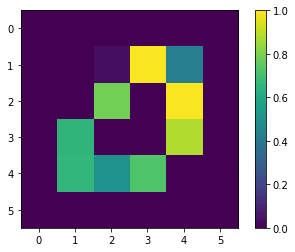

In [133]:
#import data
import collections

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

#Take only images of 3 and 6
def filter_36(x, y):
    keep = (y == 1) | (y == 0)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

x_train_small = tf.image.resize(x_train, (6,6)).numpy()
x_test_small = tf.image.resize(x_test, (6,6)).numpy()

def convert_label(y):
  if y==True:
    return 1.0
  else: 
    return -1.0

y_train=[convert_label(y) for y in y_train]
y_test=[convert_label(y) for y in y_test]

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


X_train=x_train_small[:100]
X_test=x_test_small[:20]
Y_train=y_train[:100]
Y_test=y_test[:20]

In [114]:
#Try 4 qubit gates -- to be improved later

from sympy.physics.quantum import TensorProduct
class ZZZZ(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.ZZ),cirq.unitary(cirq.ZZ))**self.symbols
  def __str__(self):
    return 'ZZZZ'


class XXXX(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.XX),cirq.unitary(cirq.XX))**self.symbols
  def __str__(self):
    return 'XXXX'

class YYYY(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.YY),cirq.unitary(cirq.YY))**self.symbols
  def __str__(self):
    return 'YYYY'

In [137]:

#Convolutional 
def one_qubit_unitary(bit, symbols):
    """Make a Cirq cir
    cuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

def conv_filter_xyz(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += one_qubit_unitary(bits[2], symbols[6:9])
    circuit += one_qubit_unitary(bits[3], symbols[9:12])
    
    for first, second in zip(bits[0::2], bits[1::2]):
      circuit += [cirq.ZZ(first,second)**symbols[12]]
      circuit += [cirq.YY(first,second)**symbols[13]]
      circuit += [cirq.XX(first,second)**symbols[14]]
    """
    for first, second in zip(bits[0::2], bits[1::2] ):
      circuit += [cirq.ZZ(first,second)**symbols[15]]
      circuit += [cirq.YY(first,second)**symbols[16]]
      circuit += [cirq.XX(first,second)**symbols[17]]
    """
    """
    #ZZZZ=cirq.MatrixGate(TensorProduct(cirq.unitary(cirq.ZZ),cirq.unitary(cirq.ZZ)))
    #YYYY=cirq.MatrixGate(TensorProduct(cirq.unitary(cirq.YY),cirq.unitary(cirq.YY)))
    #XXXX=cirq.MatrixGate(TensorProduct(cirq.unitary(cirq.XX),cirq.unitary(cirq.XX)))
    circuit += [ZZZZ(symbols[12])(*bits)]
    circuit += [YYYY(symbols[13])(*bits)]
    circuit += [XXXX(symbols[14])(*bits)]
    """
    """
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    """

    circuit += one_qubit_unitary(bits[0], symbols[15:18])
    circuit += one_qubit_unitary(bits[1], symbols[18:21])
    circuit += one_qubit_unitary(bits[2], symbols[21:24])
    circuit += one_qubit_unitary(bits[3], symbols[24:])


    #pooling
    circuit+=cirq.CNOT(control=bits[0], target=bits[1])
    circuit+=cirq.CNOT(control=bits[2], target=bits[3])
    circuit+=cirq.CNOT(control=bits[1], target=bits[3])
    return circuit



In [25]:
import random
def conv_filter(qubits, symbols):
  circuit=cirq.Circuit()
  gate_set=[cirq.rx, cirq.ry, cirq.rz]
  #symbols=sympy.symbols('qconv0:4')
  for i,q in enumerate(qubits):
    chosen_gate=random.choice(gate_set)
    circuit+=chosen_gate(symbols[i])(q)
  
  for control, target in zip(qubits, qubits[1:]+[qubits[0]]):
    circuit+=cirq.CZ(control, target)
  circuit+=cirq.CNOT(control=qubits[0], target=qubits[1])
  circuit+=cirq.CNOT(control=qubits[2], target=qubits[3])
  circuit+=cirq.CNOT(control=qubits[1], target=qubits[3])
  return circuit




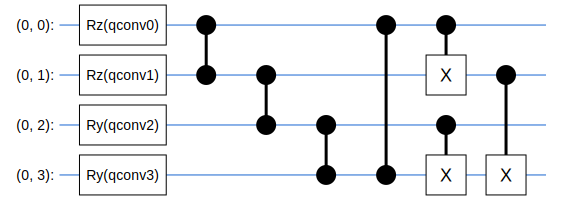

In [121]:
qubits=cirq.GridQubit.rect(1,4)
symbols=sympy.symbols('qconv0:100')
SVGCircuit(conv_filter(qubits, symbols))

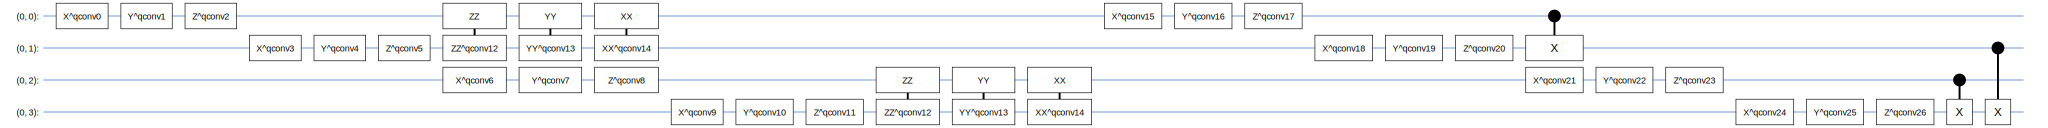

In [138]:
qubits=cirq.GridQubit.rect(1,4)
symbols=sympy.symbols('qconv0:100')
SVGCircuit(conv_filter_xyz(qubits, symbols))

In [151]:
def conv_circuit(bits, symbols): #bütün bitler -- sliding burada
  circuit=cirq.Circuit()
  n=int(np.sqrt(len(bits)))
  patch=np.array(bits).reshape((n,n))
  count=0
  for j in range(0,n,2):
    for k in range(0,n,2):
      
      circuit+= conv_filter_xyz([patch[j,k], patch[j,k+1], patch[j+1,k], patch[j+1,k+1]], symbols[count:count+27])
      count+=27
  return circuit
  


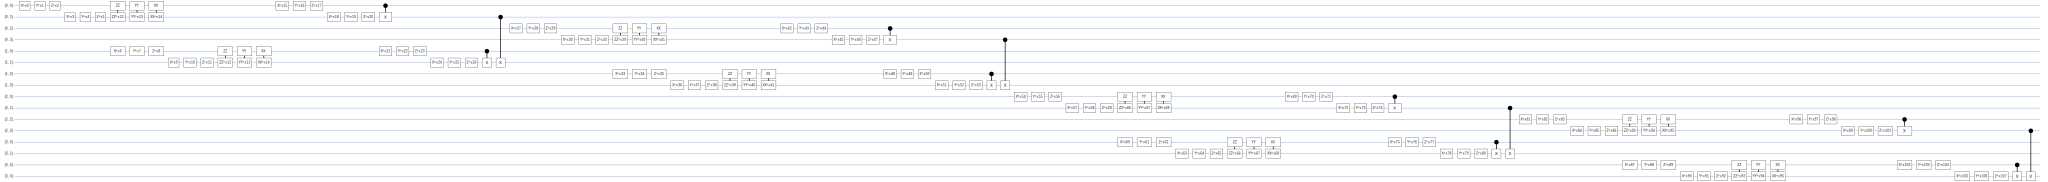

In [155]:
SVGCircuit(conv_circuit(cirq.GridQubit.rect(4,4), sympy.symbols('x0:200')))

In [43]:
index=[5,7,13,15]

In [156]:
def create_model(qubits):
  model_circuit=cirq.Circuit()
  symbols=sympy.symbols('qconv0:200')
  model_circuit+=conv_circuit(qubits, symbols[:108])
  index=[5,7,13,15]
  model_circuit+=conv_circuit([qubits[i] for i in index], symbols[108:])
  return model_circuit

qubits16=cirq.GridQubit.rect(4,4)
readout_operators=cirq.Z(qubits16[-1])

model=tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype=tf.string), 
                           tfq.layers.PQC(create_model(qubits16), readout_operators)])



In [157]:
3#encode images to quantum states

def encode_circuit_16(values):
  im4=values[1:5,1:5]
  phi=np.ndarray.flatten(im4)
  encode_circuit=cirq.Circuit()
  qubits=cirq.GridQubit.rect(4,4)
  for i in range(16):
    encode_circuit.append(cirq.ry(np.pi*phi[i])(qubits[i]))
  return encode_circuit

In [158]:
x_train_16=[encode_circuit_16(x) for x in X_train]
x_test_16=[encode_circuit_16(x) for x in X_test]

In [159]:
xx_train_16=tfq.convert_to_tensor(x_train_16)
xx_test_16=tfq.convert_to_tensor(x_test_16)

In [160]:
@tf.function
def custom_accuracy(y_true, y_pred):
  y_true=tf.squeeze(y_true)
  y_pred=tf.map_fn(lambda x: 1.0 if x>=0 else -1.0, y_pred)
  return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [161]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [162]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [163]:
history = model.fit(x=xx_train_16,
                         y=np.asarray(Y_train),
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(xx_test_16, np.asarray(Y_test)))

Epoch 1/25
7/7 [==============================] - 7s 993ms/step - loss: 1.0081 - hinge_accuracy: 0.3304 - val_loss: 0.9936 - val_hinge_accuracy: 0.6562
Epoch 2/25
7/7 [==============================] - 7s 966ms/step - loss: 1.0029 - hinge_accuracy: 0.4018 - val_loss: 0.9899 - val_hinge_accuracy: 0.8125
Epoch 3/25
7/7 [==============================] - 7s 996ms/step - loss: 0.9990 - hinge_accuracy: 0.4643 - val_loss: 0.9873 - val_hinge_accuracy: 0.8125
Epoch 4/25
7/7 [==============================] - 7s 982ms/step - loss: 0.9954 - hinge_accuracy: 0.5089 - val_loss: 0.9840 - val_hinge_accuracy: 0.8438
Epoch 5/25
7/7 [==============================] - 12s 2s/step - loss: 0.9921 - hinge_accuracy: 0.5446 - val_loss: 0.9801 - val_hinge_accuracy: 0.9375
Epoch 6/25
7/7 [==============================] - 7s 1s/step - loss: 0.9888 - hinge_accuracy: 0.5893 - val_loss: 0.9747 - val_hinge_accuracy: 0.9375
Epoch 7/25
7/7 [==============================] - 7s 1s/step - loss: 0.9844 - hinge_accuracy:

In [164]:
preds=model.predict_classes(xx_test_16)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


1.0
Prediction: [0]


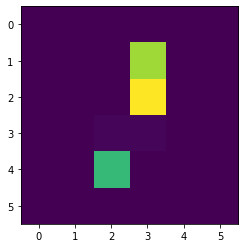

-1.0
Prediction: [0]


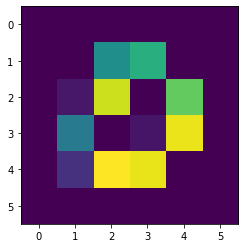

1.0
Prediction: [0]


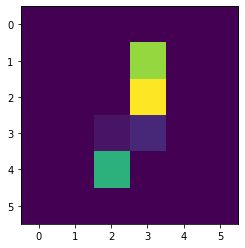

-1.0
Prediction: [0]


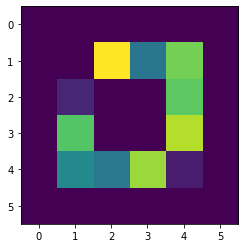

-1.0
Prediction: [0]


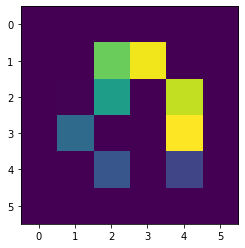

1.0
Prediction: [0]


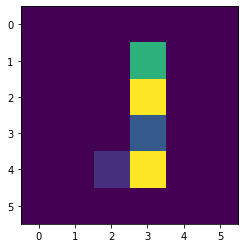

-1.0
Prediction: [0]


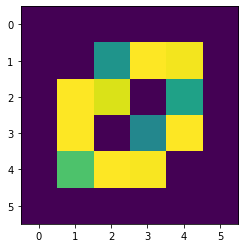

-1.0
Prediction: [0]


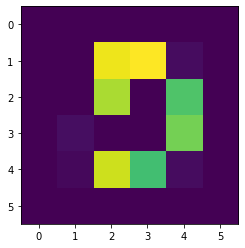

1.0
Prediction: [1]


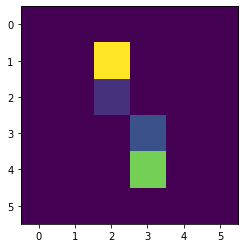

1.0
Prediction: [1]


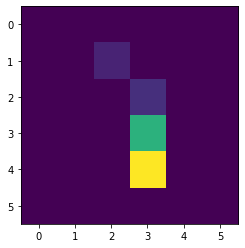

1.0
Prediction: [1]


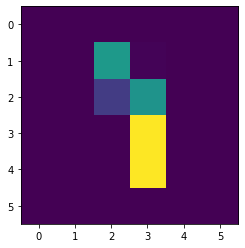

1.0
Prediction: [0]


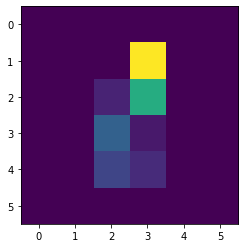

1.0
Prediction: [1]


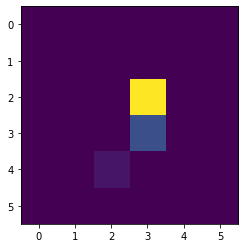

1.0
Prediction: [1]


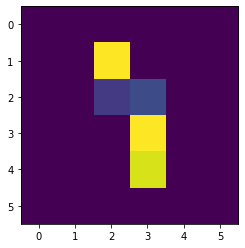

-1.0
Prediction: [0]


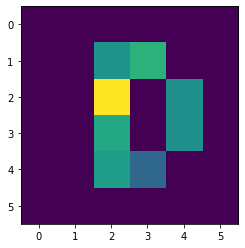

1.0
Prediction: [0]


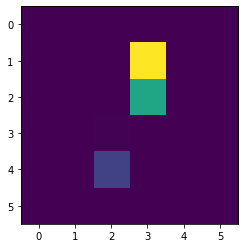

-1.0
Prediction: [0]


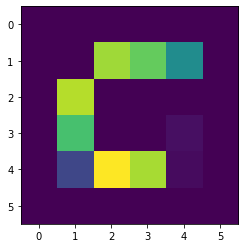

-1.0
Prediction: [0]


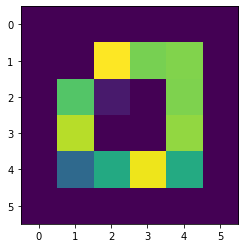

1.0
Prediction: [1]


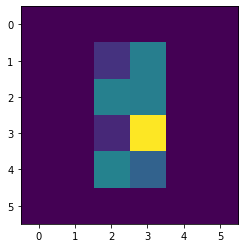

1.0
Prediction: [1]


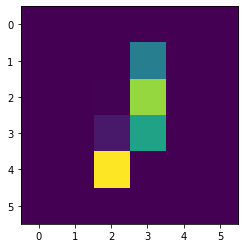

In [165]:
for i in range(len(X_test)):
  print(Y_test[i])
  print('Prediction:', preds[i])
  plt.imshow(X_test[i,:,:,0])
  plt.show()

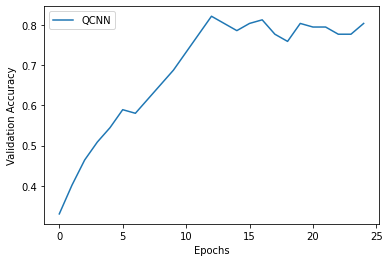

In [166]:
plt.plot(history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()